# Load Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sys import getsizeof
from collections import Counter

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F

# !pip3 uninstall -y onnx onnxruntime
# !pip3 install onnx==1.15.0 onnxruntime==1.16.3
# !pip3 uninstall -y onnx onnxruntime onnxruntime-tools onnxconverter-common

In [2]:
# !pip3 uninstall torch torchvision torchaudio -y

In [3]:
# !pip3 install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 onnx onnxruntime

In [4]:
# import torch
# import torch.nn as nn

# class DummyModel(nn.Module):
#     def forward(self, x):
#         return x * 2

# model = DummyModel()
# dummy_input = torch.randn(1, 3)

# torch.onnx.export(model, dummy_input, "dummy.onnx")

# print("ONNX export succeeded!")

# Load Data

In [5]:
# Load dataset 
data = pd.read_csv('dataset/smart_manufacturing_data.csv', parse_dates=['timestamp'])
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)
print('Original Labels:', Counter(data["anomaly_flag"].tolist()))

# Downsample data to get fewer anomalies
fraction_to_keep = 0.05
data_1 = data[data['anomaly_flag'] == 1].sample(frac=fraction_to_keep, random_state=42)
data_not_1 = data[data['anomaly_flag'] != 1]

# Combine and shuffle if needed
data = pd.concat([data_1, data_not_1]).reset_index(drop=True)
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)

print('Number of machines:', len(set(data['machine_id'].tolist())))
print('Updated Labels:', Counter(data["anomaly_flag"].tolist()))
data.head(5)

Original Labels: Counter({0: 91084, 1: 8916})
Number of machines: 50
Updated Labels: Counter({0: 91084, 1: 446})


,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 01:37:00,1,62.59,48.08,60.13,1.62,4.16,1,0,363,Normal,0.0,0
1,2025-01-01 01:42:00,1,70.88,68.67,50.57,1.05,2.36,1,0,111,Normal,0.0,0
2,2025-01-01 02:13:00,1,62.34,72.68,60.47,2.24,4.95,1,0,192,Normal,0.0,0
3,2025-01-01 02:19:00,1,88.03,53.36,50.79,3.08,2.25,1,0,301,Normal,0.0,0
4,2025-01-01 03:05:00,1,79.39,49.44,56.99,2.54,2.76,1,0,127,Normal,0.0,0


# Modeling

In [6]:
# Scale and split features
# Split by machines
machine_train = list(range(1, 41)) # 1-40
machine_test = list(range(41, 51)) # 41-50

features = ["temperature", "vibration", "humidity", "pressure", "energy_consumption"]

X_train = data[data['machine_id'].isin(machine_train)][features]
X_test = data[data['machine_id'].isin(machine_test)][features]

y_train = data[data['machine_id'].isin(machine_train)]['anomaly_flag']
y_test = data[data['machine_id'].isin(machine_test)]['anomaly_flag']

print('Train:', len(y_train))
print('Test :', len(y_test))

print('Train:', Counter(y_train))
print('Test :', Counter(y_test))

Train: 73349
Test : 18181
Train: Counter({0: 73001, 1: 348})
Test : Counter({0: 18083, 1: 98})


In [7]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Compute weights: class 0 = normal, class 1 = anomaly
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print(weights)

# Convert to tensor
class_weights = torch.tensor(weights, dtype=torch.float32)

[  0.50238353 105.38649425]


In [9]:
# Model
class AnomalyMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.out(x))  # Binary classification
    
model = AnomalyMLP(input_size=X_train.shape[1])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert your data to torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

In [10]:
# Train
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 100/2000, Loss: 1.0799
Epoch 200/2000, Loss: 0.9415
Epoch 300/2000, Loss: 0.9085
Epoch 400/2000, Loss: 0.8932
Epoch 500/2000, Loss: 0.8811
Epoch 600/2000, Loss: 0.8712
Epoch 700/2000, Loss: 0.8655
Epoch 800/2000, Loss: 0.8618
Epoch 900/2000, Loss: 0.8590
Epoch 1000/2000, Loss: 0.8567
Epoch 1100/2000, Loss: 0.8548
Epoch 1200/2000, Loss: 0.8535
Epoch 1300/2000, Loss: 0.8526
Epoch 1400/2000, Loss: 0.8518
Epoch 1500/2000, Loss: 0.8512
Epoch 1600/2000, Loss: 0.8507
Epoch 1700/2000, Loss: 0.8502
Epoch 1800/2000, Loss: 0.8499
Epoch 1900/2000, Loss: 0.8495
Epoch 2000/2000, Loss: 0.8492


In [11]:
model.eval()
with torch.no_grad():
    X_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_prob  = model(X_tensor).numpy()
    y_pred = (y_prob > 0.5).astype(int)  # threshold to get class labels

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18083
           1       0.72      0.99      0.83        98

    accuracy                           1.00     18181
   macro avg       0.86      0.99      0.92     18181
weighted avg       1.00      1.00      1.00     18181

PRE=0.72, REC=0.99, F1=0.83, AUC=1.00


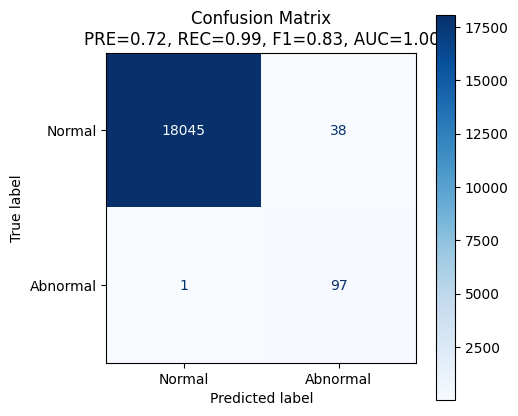

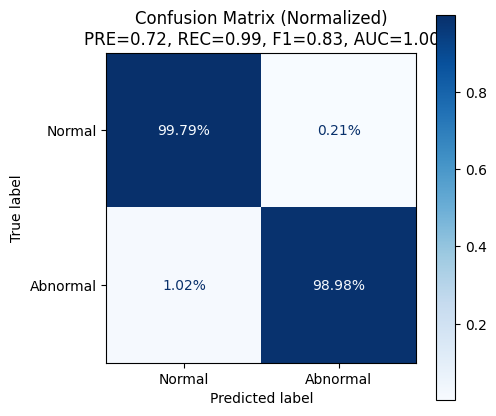

In [12]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred,average='binary')
print("Classification Report:\n", classification_report(y_test, y_pred))

results = f'PRE={prec:.2f}, REC={rec:.2f}, F1={f1:.2f}, AUC={roc_auc_score(y_test, y_prob):.2f}'
print(results)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f"Confusion Matrix\n{results}")
plt.savefig('results/nn/nn_cm.png')
plt.show()

# Normalize by true labels (rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2%')
plt.title(f"Confusion Matrix (Normalized)\n{results}")
plt.savefig('results/nn/nn_cm_normalized.png')
plt.show()

# Saving model
torch.save(model.state_dict(), "models/nn_model.pth")

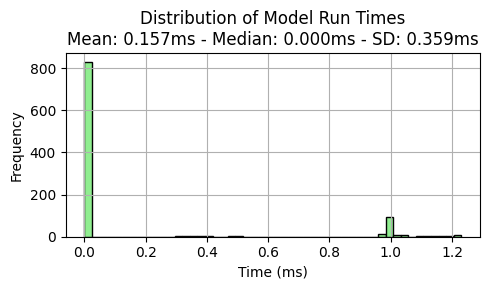

In [13]:
# Testing model speed
list_compute_time = []

for X_sample in X_test[:1000]:
    start = time.time()
    
    with torch.no_grad():
        X_tensor  = torch.tensor(X_sample, dtype=torch.float32)
        y_prob  = model(X_tensor).numpy()
        y_pred = (y_prob > 0.5).astype(int)  # threshold to get class labels
    end = time.time()
    compute_time = end-start
    list_compute_time.append(compute_time)

list_compute_time = [x*1e3 for x in list_compute_time]

mean_time = np.mean(list_compute_time)
median_time = np.median(list_compute_time)
std_dev_time = np.std(list_compute_time)

# Display the results
results = f"Mean: {mean_time:.3f}ms - Median: {median_time:.3f}ms - SD: {std_dev_time:.3f}ms"

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(list_compute_time, bins=50, edgecolor='black', color='lightgreen')
plt.title(f'Distribution of Model Run Times\n{results}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('results/nn/nn_run_time.png')
plt.tight_layout()
plt.show()

# Modelling (ONNX)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import onnx
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime import GraphOptimizationLevel

print("ONNX and ONNXRuntime are working!")

ONNX and ONNXRuntime are working!


In [15]:
# model = AnomalyMLP(X_train.shape[1])
# model.load_state_dict(torch.load("models/nn_model.pth"))
# model.eval()

# Model
class AnomalyMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.out(x))  # Binary classification

model = AnomalyMLP(5)
model.load_state_dict(torch.load("models/nn_model.pth"))
model.eval()

AnomalyMLP(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [16]:
# dummy_input = torch.randn(1, X_train.shape[1])
# torch.onnx.export(model, dummy_input, "models/nn_model.onnx", opset_version=11)

dummy_input = torch.randn(1, 5)
torch.onnx.export(model, dummy_input, "models/nn_model.onnx", opset_version=11)

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [17]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic(
    model_input="models/nn_model.onnx",
    model_output="models/nn_model_quantized.onnx",
    weight_type=QuantType.QInt8  # or QuantType.QUInt8
)

In [18]:
# Load the ONNX model
session = ort.InferenceSession("models/nn_model_quantized.onnx")

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [19]:
# Run inference in batch or loop
y_prob = []

for x in X_test:
    x_reshaped = np.array(x).reshape(1, -1).astype(np.float32)
    output = session.run([output_name], {input_name: x_reshaped})
    y_prob.append(output[0][0][0])  # assuming binary output
    
y_pred = [1 if prob > 0.5 else 0 for prob in y_prob]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18083
           1       0.79      0.92      0.85        98

    accuracy                           1.00     18181
   macro avg       0.89      0.96      0.92     18181
weighted avg       1.00      1.00      1.00     18181

PRE=0.79, REC=0.92, F1=0.85, AUC=1.00


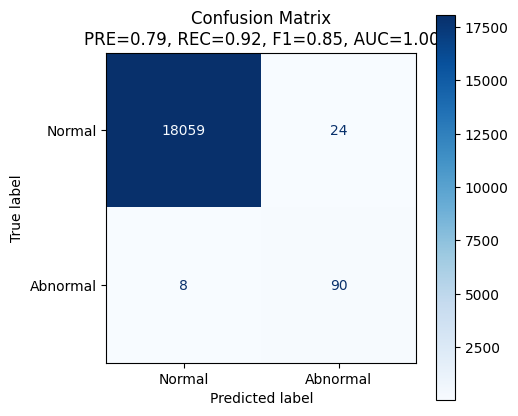

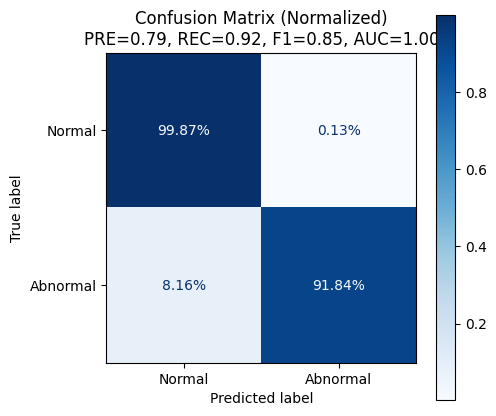

In [20]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred,average='binary')
print("Classification Report:\n", classification_report(y_test, y_pred))

results = f'PRE={prec:.2f}, REC={rec:.2f}, F1={f1:.2f}, AUC={roc_auc_score(y_test, y_prob):.2f}'
print(results)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f"Confusion Matrix\n{results}")
plt.savefig('results/nn/nn_onnx_cm.png')
plt.show()

# Normalize by true labels (rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2%')
plt.title(f"Confusion Matrix (Normalized)\n{results}")
plt.savefig('results/nn/nn_onnx_cm_normalized.png')
plt.show()

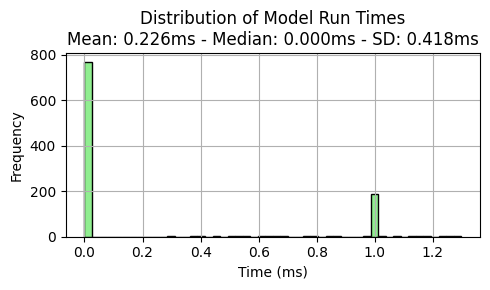

In [21]:
list_compute_time_org = list_compute_time.copy()

# Testing model speed
list_compute_time = []

for X_sample in X_test[:1000]:
    start = time.time()
    
    with torch.no_grad():
        X_tensor  = torch.tensor(X_sample, dtype=torch.float32)
        y_prob  = model(X_tensor).numpy()
        y_pred = (y_prob > 0.5).astype(int)  # threshold to get class labels
    end = time.time()
    compute_time = end-start
    list_compute_time.append(compute_time)

list_compute_time = [x*1e3 for x in list_compute_time]

mean_time = np.mean(list_compute_time)
median_time = np.median(list_compute_time)
std_dev_time = np.std(list_compute_time)

# Display the results
results = f"Mean: {mean_time:.3f}ms - Median: {median_time:.3f}ms - SD: {std_dev_time:.3f}ms"

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(list_compute_time, bins=50, edgecolor='black', color='lightgreen')
plt.title(f'Distribution of Model Run Times\n{results}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('results/nn/nn_onnx_run_time.png')
plt.tight_layout()
plt.show()

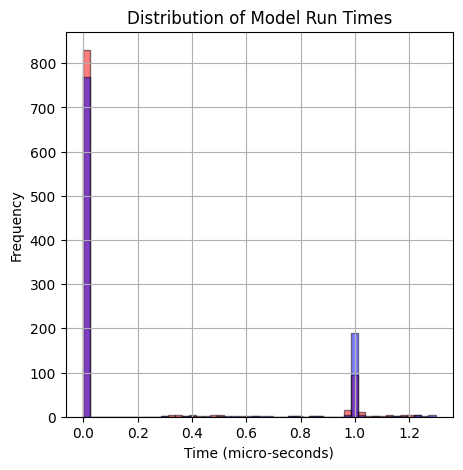

In [22]:
# Plotting the histogram
plt.figure(figsize=(5, 5))
bins = np.histogram_bin_edges(np.concatenate([list_compute_time_org, list_compute_time]), bins=50)
plt.hist(list_compute_time_org, bins=bins, edgecolor='black', color='red', alpha=0.5, label='Original')
plt.hist(list_compute_time, bins=bins, edgecolor='black', color='blue', alpha=0.5, label='Optimized')
plt.title('Distribution of Model Run Times')
plt.xlabel('Time (micro-seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('results/lgbm/lgbm_compare_run_time.png')
plt.show()